In [115]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Sep 25 10:40:42 2020
Modified on Fri Nov 05 10:40:42 2021

@author: mwall
@author-modified: sturkarslan
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
os.chdir('.')

#import miner as miner
import miner_py3_kk as miner
from tqdm.notebook import tqdm, trange
import time
import collections
from itertools import chain
from importlib import reload

# Path to the miner directory
input_path = os.getcwd()
print("Current working directory: " + input_path)

Current working directory: /Users/sturkars/github/GbmMINER


### Load Expression data for the cohort

In [121]:
expressionData = pd.read_csv("data/GbmMicroRNAMergedmRNAMicroarraymiRNAZScoredData.csv", sep=",", index_col=0, header = 0)
expressionData.head()

,TCGA-02-0055,TCGA-19-2620,TCGA-14-1825,TCGA-06-5412,TCGA-06-0882,TCGA-06-0686,TCGA-08-0386,TCGA-06-2564,TCGA-06-2563,TCGA-12-0618,...,TCGA-06-0876,TCGA-14-1827,TCGA-06-0208,TCGA-28-1752,TCGA-19-4068,TCGA-06-0673,TCGA-02-0432,TCGA-08-0520,TCGA-08-0521,TCGA-12-0826
ENSG00000283681,-0.063949,-0.981317,0.509845,-0.395647,-0.475314,-0.382054,-0.157049,0.588831,0.164849,1.328424,...,-0.436978,-1.671642,-2.176615,-1.110038,0.295915,0.610588,1.260609,-0.710774,-0.747376,-1.779463
ENSG00000283630,1.158995,-0.406467,0.573934,0.568069,-0.763429,-0.453507,-1.566507,-0.978654,-0.157679,0.370772,...,-0.585049,0.795828,1.188957,-0.763477,-0.680784,0.257256,-0.241199,-0.489461,0.396587,0.819420
ENSG00000283590,-1.074924,1.346765,-0.258079,-1.172458,1.065805,0.485607,1.486802,0.363426,-0.246750,1.810410,...,1.886381,-1.513320,-1.592093,0.452465,-0.778512,0.335211,-0.838058,0.412936,-0.872861,0.660953
ENSG00000283530,-0.786021,1.227796,-0.772202,0.684848,1.394499,-0.429553,2.035617,-0.460911,-0.416990,0.800451,...,0.137280,-0.249321,0.221870,1.424867,-0.409019,0.993109,1.208430,1.788222,-0.601130,1.335761
ENSG00000283494,-0.172053,0.274944,-0.371157,-0.246370,1.063016,0.270404,0.906337,0.029299,0.431273,-0.498009,...,-0.367852,0.356714,0.111160,0.542919,-0.667167,4.558188,1.365450,0.493600,0.631626,0.351809


### Load Regulons

In [122]:
# Load regulon Modules
regulonModules = miner.read_json(os.path.join(input_path,"data/MINER_MicroLowessRNATMM.08.24.2020/regulons.json"))
print("Total number of regulons: " + str(len(regulonModules)))
# load regulon data frame
# All Regulons
regulonDf = pd.read_csv("data/MINER_MicroLowessRNATMM.08.24.2020/regulonDf.csv", header = 0)
regulonDf = list(regulonDf['Regulon_ID'].drop_duplicates())
regulonDf = [str(i) for i in regulonDf]
regulonModules = dict((k, regulonModules[k]) for k in regulonDf if k in regulonModules)

# Disease relevant regulons
#regulonDfMicroGbmLatest = pd.read_csv("data/MINER_MicroLowessRNATMM.08.24.2020/regulonDfGbmMicroRNASigCoxAndStatSig.csv", header = 0)
#regulonDfMicroGbmLatest = list(regulonDfMicroGbmLatest['Regulon_ID'].drop_duplicates())
#regulonDfMicroGbmLatest = [str(i) for i in regulonDfMicroGbmLatest]
#regulonModules = dict((k, regulonModules[k]) for k in regulonDfMicroGbmLatest if k in regulonModules)

print("Filtered number of regulons selected: " + str(len(regulonModules)))

Total number of regulons: 3764
Filtered number of regulons selected: 3764


### Load programs

In [123]:
# Load transcriptional programs
# All Programs
transcriptional_programs = miner.read_json(os.path.join(input_path,'data/MINER_MicroLowessRNATMM.08.24.2020/transcriptional_programs.json'))
#transcriptional_programs_filtered = miner.read_json(os.path.join(input_path,'data/MINER_MicroLowessRNATMM.08.24.2020/transcriptional_programsmiRNAAndSig.json'))

program_list = [transcriptional_programs[str(key)] for key in range(len(transcriptional_programs.keys()))]
print("Total number of programs: " + str(len(transcriptional_programs)))

Total number of programs: 178


### Function to create dictionary of program genes

In [124]:
# Create dictionary of program genes
# make dictionary of program keys with gene lists as elements
def createPrGenesDictionary(program_list, regulons):
    pr_genes_expanded = {}
    for i in range(len(program_list)):
        rgns = program_list[i]
        genes = []
        for r in rgns:
            if r in regulonModules:
                genes.append(regulonModules[r])
        if len(genes) != 0:
            genes = list(set(np.hstack(genes)))
            pr_genes_expanded[i] = genes

    unique_genes = set(x for y in pr_genes_expanded.values() for x in y)
        
    print("Total number of genes: " + str(len(unique_genes)))
    return(pr_genes_expanded)


### Function to calculate program activity stats

In [125]:
def calculatePrActivityStats(program_activity):
    # calculate Program activity stats
    over_active = (program_activity == 1).astype(int).sum(axis=0)
    under_active = (program_activity == -1).astype(int).sum(axis=0)
    neutral = (program_activity == 0).astype(int).sum(axis=0)

    program_summary = pd.concat([over_active,under_active,neutral],  axis=1, keys = ['Over','Under','Neutral'], names = ['Over','Under','Neutral'])
    program_summary


    _ = plt.hist(over_active,bins=20,color='#0A6ECC',edgecolor="black",alpha=0.75, label="Over")
    _ = plt.hist(under_active,bins=20,color='#0ACCDD',edgecolor="black",alpha=0.75, label="Under")
    _ = plt.hist(neutral,bins=20,color='#CCFFEE',edgecolor="black",alpha=0.75,label="Neutral")
    plt.title("Program Activity Summary")
    plt.legend()
    plt.show()


### Function to Calculate Program activity

In [126]:
def calculateProgramActivity(program_list,regulons,expressionData,outputFile):
    
    # select reference dictionary for downstream analysis (pr_genes, revisedClusters, coexpressionModules, or regulonModules)
    referenceDictionary = createPrGenesDictionary(program_list,regulons)

    # create a background matrix used for statistical hypothesis testing
    bkgd = miner.backgroundDf(expressionData)

    # for each cluster, give samples that show high coherent cluster activity
    overExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)

    # for each clus|ter, give samples that show low coherent cluster activity
    underExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)

    # convert overExpressedMembers dictionary to binary matrix
    overExpressedProgramsMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)

    # convert underExpressedMembers dictionary to binary matrix
    underExpressedProgramsMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)

    # Create program matrix with values of {-1,0,1}
    dfr_programs = overExpressedProgramsMatrix-underExpressedProgramsMatrix
    
    # Write program activity into a outFile
    dfr_programs.to_csv(outputFile)
    
    return(dfr_programs)

### Program activity calculations

In [127]:
program_activity = calculateProgramActivity(program_list,regulonModules,expressionData,outputFile="output/program_activity_all.csv")

Total number of genes: 6781
biclusterMembershipDictionary is done!
biclusterMembershipDictionary is done!


### Program Activity Stats

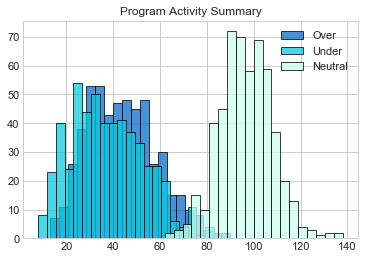

In [128]:
calculatePrActivityStats(program_activity)

Text(181.05629139072846, 0.5, 'Programs')

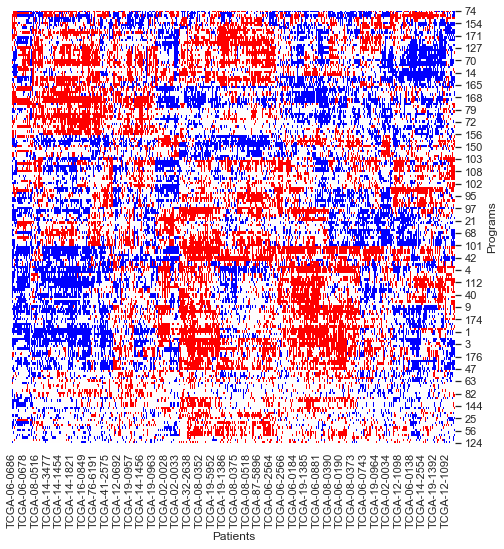

In [129]:
import seaborn as sns; sns.set()

g = sns.clustermap(program_activity,row_cluster=True,col_cluster=True,cmap="bwr",vmin=-1,vmax=1)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
g.cax.set_visible(False)
ax = g.ax_heatmap
ax.set_xlabel('Patients')
ax.set_ylabel('Programs')


In [111]:
program_activity

,TCGA-06-0125.1,TCGA-06-0190.1,TCGA-28-2499,TCGA-06-0210.1,TCGA-06-AABW,TCGA-19-4065,TCGA-19-4065.1,TCGA-14-1034.1,TCGA-02-0055,TCGA-06-0211.1,...,TCGA-06-0876,TCGA-14-1827,TCGA-06-0208,TCGA-28-1752,TCGA-19-4068,TCGA-06-0673,TCGA-02-0432,TCGA-08-0520,TCGA-08-0521,TCGA-12-0826
0,0.0,1.0,1.0,1.0,-1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,-1.0,-1.0,0.0,1.0,0.0
1,1.0,1.0,0.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,1.0,0.0
2,0.0,1.0,0.0,1.0,-1.0,1.0,0.0,-1.0,1.0,1.0,...,0.0,-1.0,-1.0,1.0,0.0,-1.0,-1.0,-1.0,0.0,-1.0
3,1.0,1.0,0.0,0.0,-1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,-1.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,1.0,0.0
4,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,...,0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0
5,1.0,1.0,-1.0,1.0,-1.0,0.0,1.0,-1.0,1.0,1.0,...,0.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,1.0,-1.0
6,1.0,1.0,0.0,0.0,-1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,-1.0,1.0,0.0
7,1.0,1.0,0.0,0.0,-1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0
8,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,1.0,-1.0
9,1.0,1.0,-1.0,1.0,-1.0,0.0,1.0,-1.0,1.0,1.0,...,0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,0.0


## Program survival analysis

### Load primary survival data

In [112]:
# load primary survival data (i.e., corresponding to expression data training set)
survival_data = pd.read_csv(os.path.join(input_path,"data/TCGA_Survival_Gbm.csv"),index_col=0,header=0)
survival_data = survival_data.iloc[:,0:2]
survival_data.columns = ["duration","observed"]
survival_data.head()

#overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
kmDf = miner.kmAnalysis(survivalDf=survival_data,durationCol="duration",statusCol="observed")
guanSurvivalDf= miner.guanRank(kmSurvival=kmDf)
guanSurvivalDf.head()
#guanSurvivalDfMMRF.to_csv("guanSurvivalDf_TCGA_GBM.csv")

,duration,observed,kmEstimate,GuanScore
Patient_ID,,,,
TCGA-12-0657,3,1,0.998062,1.000000
TCGA-19-2624,5,1,0.996113,0.998047
TCGA-41-4097,6,1,0.992214,0.995111
TCGA-06-0140,6,1,0.992214,0.995111
TCGA-06-0402,8,1,0.990261,0.992184


In [116]:
reload(miner)

<module 'miner_py3_kk' from '/Users/sturkars/github/GbmMINER/miner_py3_kk.py'>

### Survival analysis of Programs

Total number of genes: 6781
Completed 0 of 35 iterations
Completed 0 of 35 iterations
Completed 0 of 36 iterations
Completed 0 of 36 iterations
Completed 0 of 36 iterations

High-risk programs:
           HR   p-value
6    4.051721  0.000051
12   3.408121  0.000654
33   3.387876  0.000704
167  3.223738  0.001265
48   3.222830  0.001269

Low-risk programs
           HR   p-value
66  -2.355455  0.018500
147 -2.811286  0.004934
146 -3.048244  0.002302
72  -3.184500  0.001450
75  -4.106839  0.000040
4.356069087982178


Text(0.5, 0, 'Time (days)')

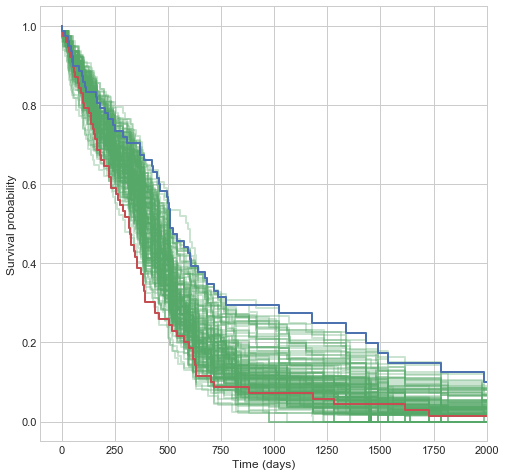

In [117]:
# Cox proportional hazards regression of transcriptional programs
t1 = time.time()

# Get program genes
pr_genes_expanded = createPrGenesDictionary(program_list,regulonModules)

#
cox_programs_output = miner.parallelMedianSurvivalAnalysis(pr_genes_expanded,expressionData,guanSurvivalDf,numCores=5)
cox_programs_output = cox_programs_output.iloc[np.argsort(np.array(cox_programs_output.index).astype(int))]
#cox_programs_output.to_csv(os.path.join(resultsDirectory,'CoxProportionalHazardsProgramsSig.csv'))
cox_programs_output.sort_values(by="HR",ascending=False,inplace=True)

print("\nHigh-risk programs:")
print(cox_programs_output.iloc[0:5,:])
print("\nLow-risk programs")
print(cox_programs_output.iloc[-5:,:])

t2 = time.time()
print(t2-t1)

# Kaplan-Meier plot of all programs (median expression)
srv = guanSurvivalDf.copy()
keys = list(pr_genes_expanded.keys())

plt.figure(figsize=(8,8))
plt.style.use('seaborn-whitegrid')
plt.xlim(-100,2000)

for key in keys:
    cluster = np.array(expressionData.loc[pr_genes_expanded[key],:])
    median_ = np.mean(cluster,axis=0)
    threshold = np.percentile(median_,85)
    median_[median_>=threshold] = 1
    median_[median_<threshold] = 0
    membership_df = pd.DataFrame(median_)
    membership_df.index = expressionData.columns
    membership_df.columns = [key]

    cox_hr, cox_p = miner.survivalMembershipAnalysisDirect(membership_df,guanSurvivalDf)

    groups = [membership_df.index[np.where(membership_df[key]==1)[0]]]
    labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]
    miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
                 filename=None,lw=2,color="gray",alpha=0.3)  


key_min = cox_programs_output.index[0]
key_max = cox_programs_output.index[-1]

cluster = np.array(expressionData.loc[pr_genes_expanded[key_min],:])
median_ = np.mean(cluster,axis=0)
threshold = np.percentile(median_,85)
median_[median_>=threshold] = 1
median_[median_<threshold] = 0
membership_df = pd.DataFrame(median_)
membership_df.index = expressionData.columns
membership_df.columns = [key_min]

cox_hr, cox_p = miner.survivalMembershipAnalysisDirect(membership_df,guanSurvivalDf)

groups = [membership_df.index[np.where(membership_df[key_min]==1)[0]]]
labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]

miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
             filename=None,lw=2,color="red",alpha=1)  

    
cluster = np.array(expressionData.loc[pr_genes_expanded[key_max],:])
median_ = np.mean(cluster,axis=0)
threshold = np.percentile(median_,85)
median_[median_>=threshold] = 1
median_[median_<threshold] = 0
membership_df = pd.DataFrame(median_)
membership_df.index = expressionData.columns
membership_df.columns = [key_max]

cox_hr, cox_p = miner.survivalMembershipAnalysisDirect(membership_df,guanSurvivalDf)

groups = [membership_df.index[np.where(membership_df[key_max]==1)[0]]]
labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]

miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
             filename=None,lw=2,color="blue",alpha=1) 
plt.ylabel('Survival probability')
plt.xlabel('Time (days)')
#plt.savefig(os.path.join(resultsDirectory,"kmplots_programsSig.pdf"),bbox_inches="tight")